In [4]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from typing import List
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

In [2]:
img_height = 224
img_width = 224
batch_size = 1

# Set augmentation and pre-processing
test_datagen = CustomDataGenerator(
                    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [3]:
model = load_VGG_model(img_height=224, img_width=224, lr=1e-3, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], trainable=True)

In [ ]:
cls_to_file_idx = dict()
for cl in range(len(test_set.class_indices)):
    cls_to_file_idx[cl] = list(np.nonzero(np.array(test_set.classes)==cl)[0])

In [25]:
from tensorflow.keras.models import Model

layer_name = 'block4_conv3'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [37]:
np.var(np.concatenate([intermediate_output, intermediate_output]))

7329.236

In [40]:
vars = dict()
for k in cls_to_file_idx.keys():
    outputs = []
    for idx in cls_to_file_idx[k]:
        outputs.append(intermediate_layer_model.predict(test_set[idx][0][tf.newaxis, ...]))
    vars[k] = np.var(np.concatenate(outputs))

In [1]:
import pickle

In [2]:
with open('class_var.pkl', 'rb') as f:
    class_var = pickle.load(f)
with open('class_acc.pkl', 'rb') as f:
    class_acc = pickle.load(f)

In [8]:
class_var = dict(sorted(class_var.items(), key=lambda item: item[1], reverse=True))

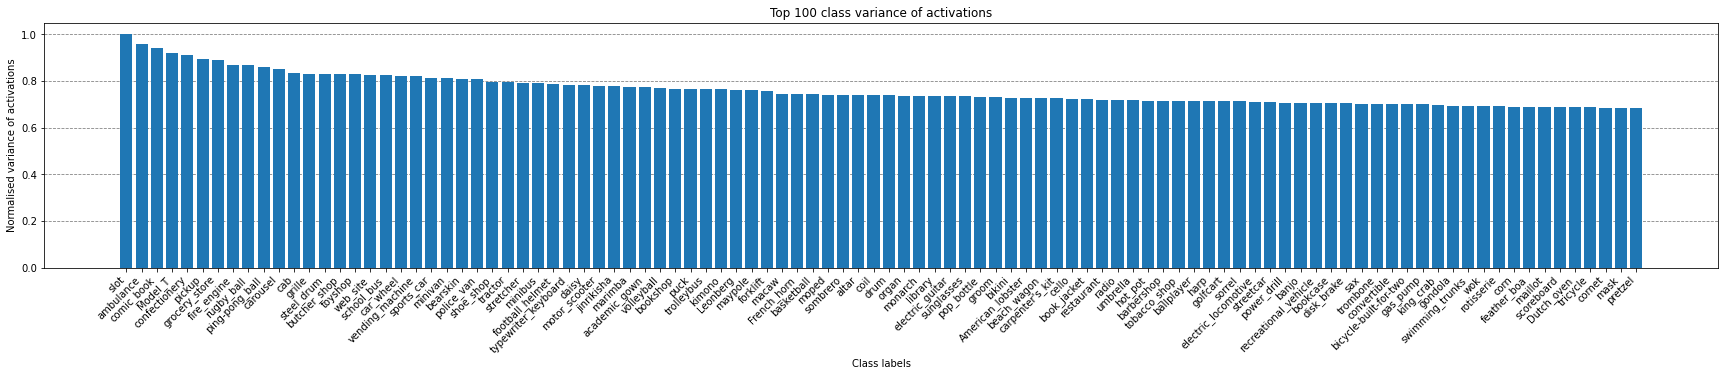

In [15]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.bar(list(class_var.keys())[:100], list(class_var.values())[:100]/max(list(class_var.values())))
ax.set_ylabel('Normalised variance of activations')
ax.set_xlabel('Class labels')
ax.set_title('Top 100 class variance of activations')
fig.autofmt_xdate(rotation=45)
fig.savefig('class_var.png')

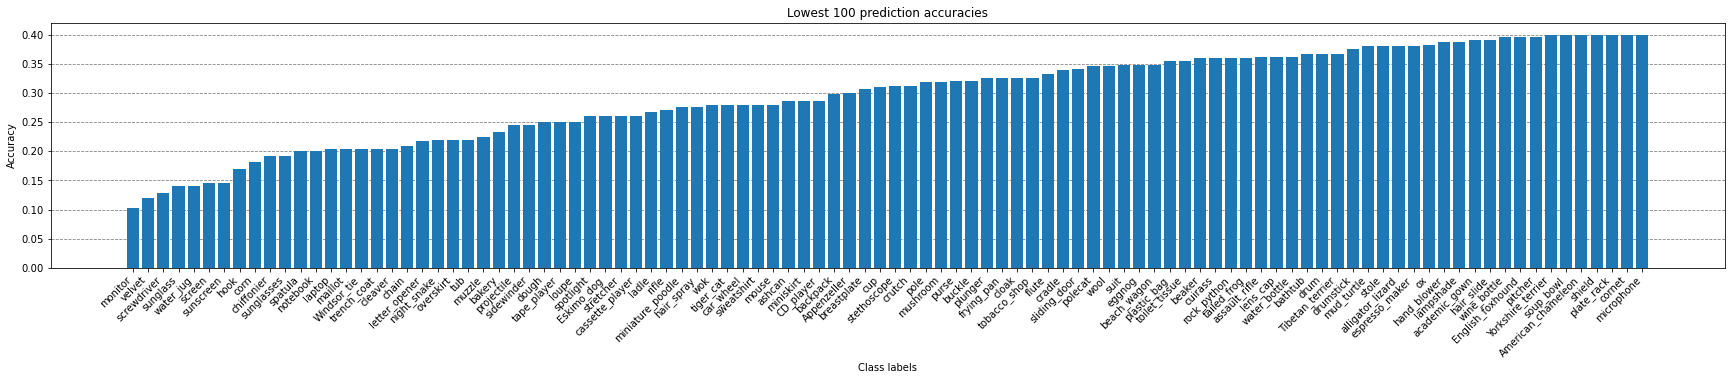

In [16]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.bar(list(class_acc.keys())[:100], list(class_acc.values())[:100])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Class labels')
ax.set_title('Lowest 100 prediction accuracies')
fig.autofmt_xdate(rotation=45)
fig.savefig('class_acc.png')